We now apply the best model found in the previous part, i.e: the Random Forest, to look for the combination of parameters *gammaness* and *alpha_cut* that maximizes the quality factor *Q*. What we do is label as background (hadrons) all samples with fAlpha greater than the *alpha_cut* value considered; then we apply the best Random Forest classification to the remaining samples, labelling as gammas only the samples with a predicted probability of belonging to class +1 greater than *gammaness*. Then we determine the TPR and FPR to calculate the correspondent Q value.    
To avoid choosing the best combination of *alpha cut* and *gammaness* solely on the performance on a specific test set, we run the same algorithm on different test sets and choose as best case the one that returns the highest average Q value over the iterations.

In [11]:
data_rescaled_and_indexed['fAlpha']= data_rescaled_and_indexed['fAlpha']*data['fAlpha'].std() + data['fAlpha'].mean()

In [13]:
N=10
test_predictions=[]
gammaness= np.arange(0.8,0.96,0.01)
alpha_cut= np.arange(2,15,1)

for i in range(1,N+1):
    print('Iteration:',i,'\n')
    
    train_set, test_set = split_train_test_set( data_rescaled_and_indexed, 5)
    X_train, Y_train = split_X_Y(train_set)
    X_test, Y_test = split_X_Y(test_set)
    
    best_forest = RandomForestClassifier(n_estimators=290, max_depth= 28, max_features=X_train.shape[1],bootstrap=True,max_samples=1.0,random_state=10,n_jobs=-1)
    best_forest.fit(X_train,Y_train) 

    for alpha in alpha_cut:
        print('\n')
        for g in gammaness:

            test_data = [ X_test[ X_test['fAlpha']<alpha], Y_test[X_test['fAlpha']<alpha] ] 
            discarded_data = X_test[X_test['fAlpha'] >= alpha]
            discarded_labels = Y_test[X_test['fAlpha'] >= alpha] # we directly classify these points as hadrons 
            
            y_pred_prob = best_forest.predict_proba(test_data[0])[:, 1]
            y_pred_label = np.where(y_pred_prob > g, 1, -1)
        
            selected_gammas= np.sum(y_pred_label==1)
            selected_hadrons= np.sum(y_pred_label==-1) + ( X_test.shape[0]-len(test_data[0])) # samples in alpha cut classified as hadron by the model + all samples previously discarded
    
            total_gammas = np.sum(Y_test==1) # over all the test set (before alpha cut)
            total_hadrons = np.sum(Y_test==-1)
            
            true_positives = np.sum( (y_pred_label==1) & (test_data[1]==1) )
            false_positives = np.sum( (y_pred_label==1) & (test_data[1]==-1) )
            true_negatives= np.sum((y_pred_label == -1) & (test_data[1] == -1)) + np.sum((discarded_labels == -1))
            false_negatives= np.sum((y_pred_label == -1) & (test_data[1] == 1)) + np.sum((discarded_labels == 1))
            
            if false_positives != 0:
                epsilon_gamma = true_positives / total_gammas # TPR
                epsilon_hadron = false_positives / total_hadrons # FPR
                Q = epsilon_gamma/np.sqrt(epsilon_hadron)
            else:
                epsilon_hadron= 0
                epsilon_gamma = true_positives / total_gammas
                Q = 'inf'
                
            test_predictions.append({
            'iteration': i,   
            'alpha_cut': alpha,
            'gamma': g,
            'test_data': test_data, 
            'pred_probs': y_pred_prob,
            'pred label': y_pred_label,
            'selected gammas': selected_gammas,
            'selected hadrons': selected_hadrons,
            'total gammas': total_gammas,
            'total hadrons': total_hadrons,
            'true positives': true_positives,
            'false positives': false_positives,
            'true negatives': true_negatives,
            'false negatives': false_negatives,
            'Q': Q })

            if Q != 'inf':
                print(f"With alpha cut {alpha} and gammaness {g:.2f}, Q = {Q:.4f}")
            else:
                print(f"With alpha cut {alpha} and gammanesss {g:.2f}, Q = {Q}")
            print(f"True positives {true_positives}; False positives {false_positives}")
    

Iteration: 1 



With alpha cut 2 and gammaness 0.80, Q = 1.6351
True positives 316; False positives 9
With alpha cut 2 and gammaness 0.81, Q = 1.6144
True positives 312; False positives 9
With alpha cut 2 and gammaness 0.82, Q = 1.7013
True positives 310; False positives 8
With alpha cut 2 and gammaness 0.83, Q = 1.6958
True positives 309; False positives 8
With alpha cut 2 and gammaness 0.84, Q = 1.8012
True positives 307; False positives 7
With alpha cut 2 and gammaness 0.85, Q = 1.7777
True positives 303; False positives 7
With alpha cut 2 and gammaness 0.86, Q = 1.7660
True positives 301; False positives 7
With alpha cut 2 and gammaness 0.87, Q = 1.7425
True positives 297; False positives 7
With alpha cut 2 and gammaness 0.88, Q = 1.7190
True positives 293; False positives 7
With alpha cut 2 and gammaness 0.89, Q = 1.6780
True positives 286; False positives 7
With alpha cut 2 and gammaness 0.90, Q = 2.1809
True positives 281; False positives 4
With alpha cut 2 and gammaness 0.91, 

To handle the very few cases that return 0 false positives and thus an "infinite" Q value, we decide to consider the median of the Q values across the different iterations instead of the average. To estimate the standard deviation of the values found we ignore these cases.     

In [14]:
test_predictions_df = pd.DataFrame(test_predictions)
test_predictions_df['Q'] = test_predictions_df['Q'].replace('inf', 1e20) # assign very high value to Q to find median
test_predictions_df.groupby(['alpha_cut', 'gamma'])['Q'].agg(
    median_Q = 'median',
    std= lambda x: np.std(x[x != 1e20])).reset_index()

,alpha_cut,gamma,median_Q,std
0,2,0.80,1.717138,0.186885
1,2,0.81,1.787606,0.173683
2,2,0.82,1.776653,0.215635
3,2,0.83,1.864144,0.216674
4,2,0.84,1.960847,0.185657
...,...,...,...,...
203,14,0.91,2.699509,0.231376
204,14,0.92,2.721513,0.247925
205,14,0.93,2.793130,0.314908
206,14,0.94,2.904786,0.338199


In [15]:
grouped_pred = test_predictions_df.groupby(['alpha_cut', 'gamma'])['Q'].agg(
    median= 'median',
    std= lambda x: np.std(x[x != 1e20]) ).reset_index()

max_mean_row = grouped_pred.loc[grouped_pred['median'].idxmax()]

max_mean = max_mean_row['median']
std_dev = max_mean_row['std']

print(f"The best average Q value found is {max_mean:.2f} ± {std_dev/(N)**0.5:.2f}")
print(f"The best Alpha cut found is {max_mean_row['alpha_cut']:.0f}° ")
print(f"The best gammaness found is {max_mean_row['gamma']:.2f}")

The best average Q value found is 3.01 ± 0.15
The best Alpha cut found is 13° 
The best gammaness found is 0.95


In [16]:
selected = test_predictions_df[
    (test_predictions_df['gamma'] == 0.9500000000000002) & 
    (test_predictions_df['alpha_cut'] == 13.0)]

selected_gammas = selected['selected gammas']/selected['total gammas']
avg_selected_gammas= selected_gammas.mean()
std_selected_gammas= selected_gammas.std()
print(f"With these best parameters, the average fraction of selected gammas is ({avg_selected_gammas*100:.1f} ± {std_selected_gammas*100/(N)**0.5:.1f})%")

With these best parameters, the average fraction of selected gammas is (36.0 ± 0.2)%


This means that, applying this technique on the given dataset with $N_{\gamma} = 12332$ true gamma events, we would identify $n_{\gamma} = (4440 ± 25)$ events as gamma, disregarding the remaining as backgorund. In particular we have the following average performance for the algorithm in terms of TPR, FPR, TNR, FNR:

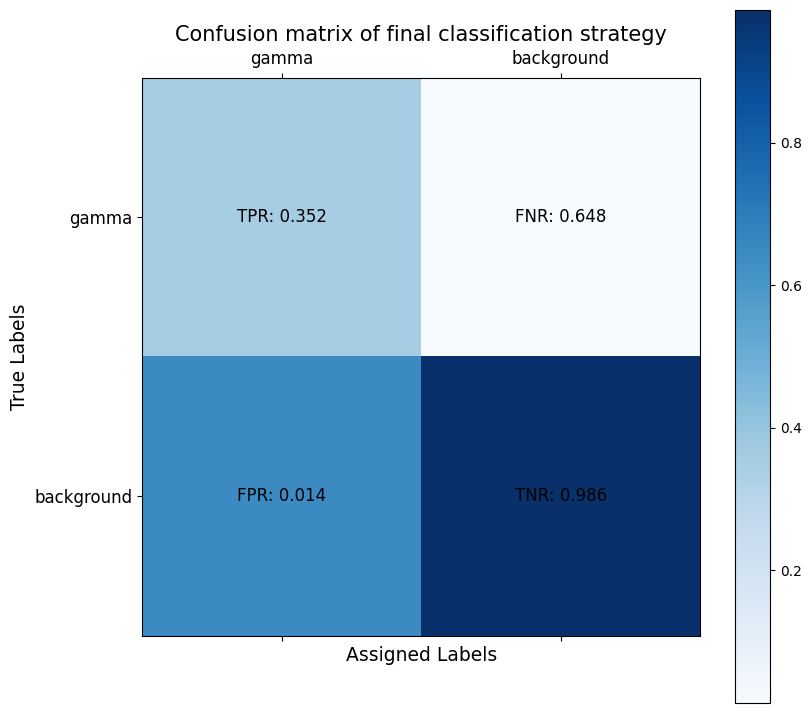

In [26]:

tpr = selected['true positives']/selected['total gammas']
tpr_avg = tpr.mean()

fpr = selected['false positives']/selected['total hadrons']
fpr_avg = fpr.mean()

tnr = selected['true negatives']/selected['total hadrons']
tnr_avg= tnr.mean()

fnr = selected['false negatives']/selected['total gammas']
fnr_avg= fnr.mean()

confusion_matrix = np.array([[tpr_avg, fpr_avg], [fnr_avg, tnr_avg]])

fig, ax = plt.subplots(figsize=(9, 9))
cax = ax.matshow(confusion_matrix, cmap='Blues')

ax.set_xticks([0, 1])
ax.set_xticklabels(['gamma', 'background'],fontsize=12)
ax.set_yticks([0, 1])
ax.set_yticklabels(['gamma', 'background'],fontsize=12)


ax.text(0, 0, f'TPR: {tpr_avg:.3f}', ha='center', va='center', color='black',fontsize=12)
ax.text(1, 0, f'FNR: {fnr_avg:.3f}', ha='center', va='center', color='black',fontsize=12)
ax.text(0, 1, f'FPR: {fpr_avg:.3f}', ha='center', va='center', color='black',fontsize=12)
ax.text(1, 1, f'TNR: {tnr_avg:.3f}', ha='center', va='center', color='black',fontsize=12)

fig.colorbar(cax)

ax.set_title('Confusion matrix of final classification strategy',fontsize=15)
ax.set_xlabel('Assigned Labels',fontsize=13.5)
ax.set_ylabel('True Labels',fontsize=13.5)

plt.show()